# Segmentation, Morphological Operations, Object Properties in Images

## Segmentation Use Case

**Problem Statement**

Target users:
- Agricultural cooperatives
- Fruit exporters in India

Hypothetical Current method:
- Manual apple counting in orchards
- Workers physically inspect trees

Problems with manual surveys:
- Time-consuming & Expensive
- Inconsistent results:
    - Human fatigue
    - Different counting standards between workers

Consequences:
- Delayed harvest planning
- Uncertainty in export contracts
- Risk of incorrect yield estimates

**Use Case**

Users:
- Orchard managers

Need:
- Automated apple detection from smartphone photos

Tasks:
- Count number of apples (yield estimation)
- Measure apple size for quality grading

Technical requirements:
- Segment individual apples

Handle:
- Leaves and branches
- Varying lighting conditions
- Complex backgrounds

Expected workflow:
- One person takes photos of multiple trees
- System returns:
    - Apple count
    - Size distribution
    - Results delivered quickly

**Objective**

Goal:
- Build an image segmentation pipeline

Performance targets:
- Apple detection & counting accuracy: ≥ 90%

Size measurement:
- Small: < 5 cm
- Medium: 5–7 cm
- Large: > 7 cm

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
from skimage.morphology import disk, binary_opening, binary_closing, binary_erosion, binary_dilation

In [12]:
# Load image
apple_tree = io.imread('../images/apple_tree.jpg')

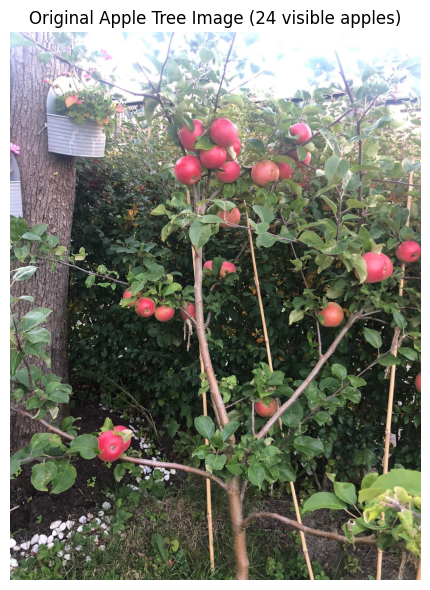

In [59]:
plt.figure(figsize=(8, 6))
plt.imshow(apple_tree)
plt.title('Original Apple Tree Image (24 visible apples)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Reshape image to pixel array (RGB values)
pixels = apple_tree.reshape((-1, 3)).astype(float)

# Test different K values
k_values = [2, 3, 4, 5, 6, 7, 8]
kmeans_results = {}

for k in k_values:
    print(f"\nTesting K={k}...")
    
    # Apply K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    # Reshape back to image
    segmented = labels.reshape(apple_tree.shape[:2])
    
    # Identify apple cluster (highest red channel in centroids)
    centroids = kmeans.cluster_centers_
    
    # Create apple mask
    
    kmeans_results[k] = {
        'segmented': segmented,
        'centroids': centroids
    }
    
    print(f"  Centroids (RGB): {centroids}")


Testing K=2...
  Centroids (RGB): [[ 64.78292827  70.31030765  54.40092936]
 [192.44743802 187.5993481  179.30681404]]

Testing K=3...
  Centroids (RGB): [[135.45421114 133.47185945 112.8088577 ]
 [225.56902146 224.03026027 225.17281843]
 [ 46.92925794  52.86672109  39.96192424]]

Testing K=4...
  Centroids (RGB): [[233.80093408 234.91640967 237.37066442]
 [ 39.09346974  44.7116115   33.7870825 ]
 [166.52577551 156.67229817 141.82460896]
 [100.859681   106.80267911  83.71549341]]

Testing K=5...
  Centroids (RGB): [[132.98011298 132.44803194 109.37604202]
 [ 33.6696278   39.12213334  29.48666097]
 [186.06148134 173.64978606 167.2144297 ]
 [ 79.73521491  86.94024571  66.14532826]
 [239.51446767 242.11011136 244.70559286]]

Testing K=6...
  Centroids (RGB): [[ 68.64084464  75.28676946  57.13014568]
 [197.22436907 188.77688201 187.49290337]
 [159.18020331 148.71860203 130.26607746]
 [243.17777756 246.33558612 248.69191377]
 [111.19320753 117.2055932   92.95635257]
 [ 30.72869291  36.0563

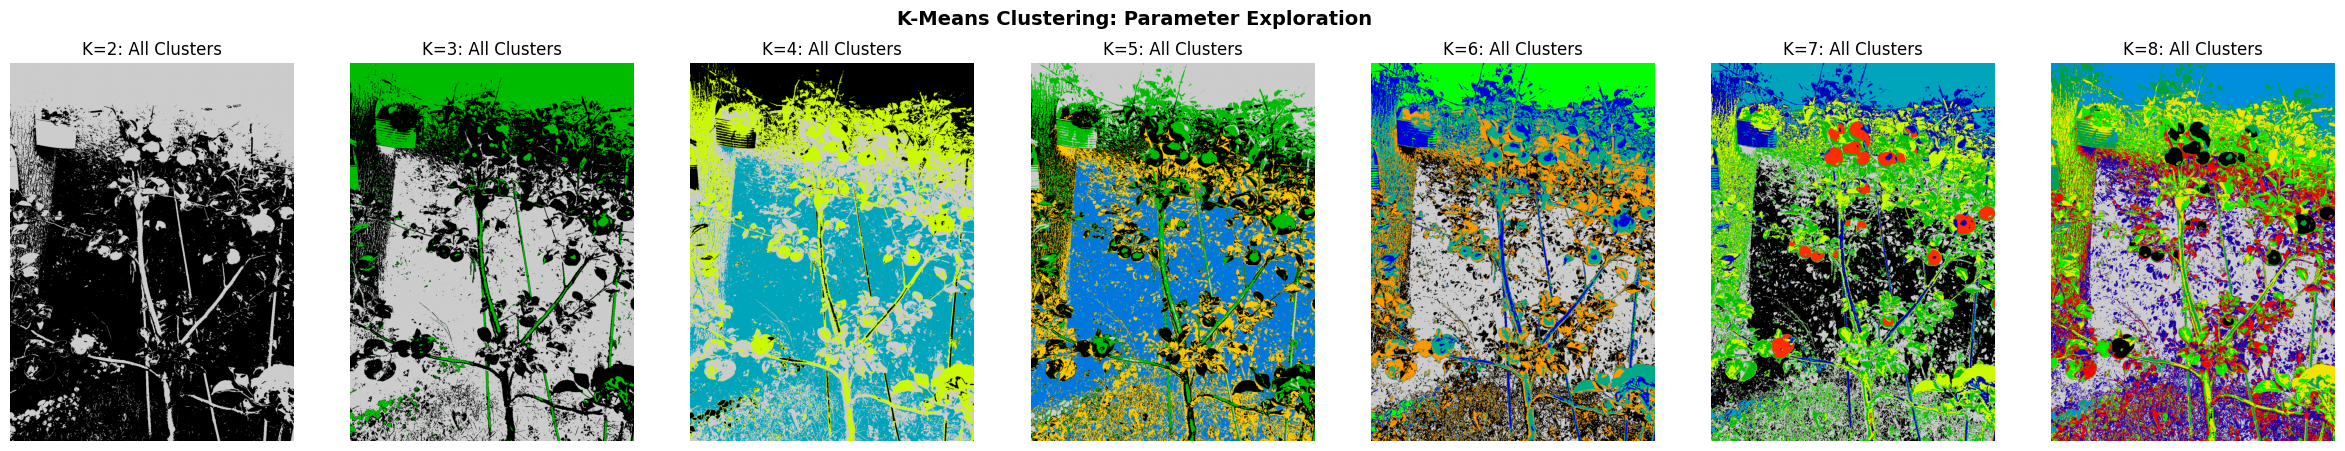

In [ ]:
# Visualize K-means results
fig, axes = plt.subplots(1, 7, figsize=(30, 10))

for idx, k in enumerate(k_values):
    # Top row: Segmented (all clusters colored)
    axes[idx].imshow(kmeans_results[k]['segmented'], cmap='nipy_spectral')
    axes[idx].set_title(f'K={k}: All Clusters')
    axes[idx].axis('off')

plt.suptitle('K-Means Clustering: Parameter Exploration', fontsize=14, fontweight='bold')
plt.show()


In [36]:
kmeans_results[7]

{'segmented': array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [6, 6, 6, ..., 1, 1, 1],
        [6, 6, 6, ..., 1, 1, 1],
        [6, 6, 6, ..., 1, 1, 1]], shape=(1600, 1200), dtype=int32),
 'centroids': array([[ 29.67318015,  34.96559456,  26.2957989 ],
        [192.41858012, 188.76491595, 185.17361628],
        [242.63791844, 245.60579076, 247.9682566 ],
        [105.43118285, 112.45971739,  88.2382483 ],
        [145.65033864, 151.61224413, 127.42853756],
        [217.52500501, 104.017998  , 118.877998  ],
        [ 65.04460702,  71.53590151,  54.30460938]])}

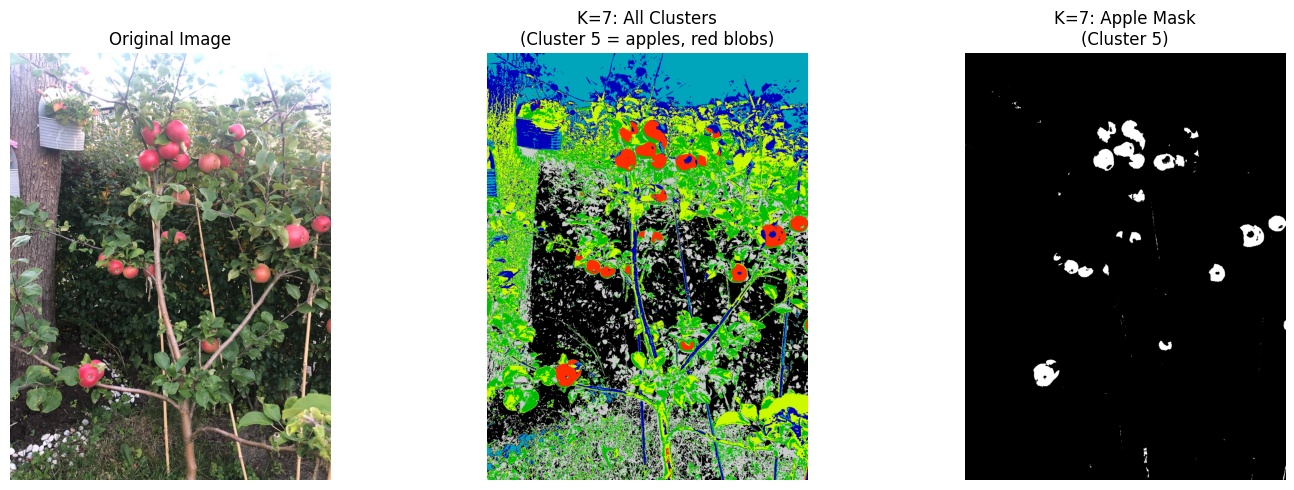

Apple pixels detected: 49931


In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(apple_tree)
axes[0].set_title('Original Image')
axes[0].axis('off')

# All clusters colored
axes[1].imshow(kmeans_results[7]['segmented'], cmap='nipy_spectral')
axes[1].set_title('K=7: All Clusters\n(Cluster 5 = apples, red blobs)')
axes[1].axis('off')

# Create mask for centroid 5 (the apples)
segmented = kmeans_results[7]['segmented']
apple_mask = (segmented == 5).astype(np.uint8)

axes[2].imshow(apple_mask, cmap='gray')
axes[2].set_title('K=7: Apple Mask\n(Cluster 5)')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('day10_kmeans_corrected.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Apple pixels detected: {np.sum(apple_mask)}")

In [20]:
otsu_results = {}

# Test 1: Red channel only
print("\nTest 1: Red channel...")
red_channel = apple_tree[:, :, 0]
threshold_red = threshold_otsu(red_channel)
mask_red = (red_channel > threshold_red).astype(np.uint8)

otsu_results['red'] = {
    'channel': red_channel,
    'threshold': threshold_red,
    'mask': mask_red
}
print(f"  Threshold: {threshold_red}")

# Test 2: Red-Green difference (enhances apple vs leaf contrast)
print("\nTest 2: Red - Green difference...")
rg_diff = apple_tree[:, :, 0].astype(int) - apple_tree[:, :, 1].astype(int)
# Normalize to 0-255 range for Otsu
rg_diff_norm = ((rg_diff - rg_diff.min()) / (rg_diff.max() - rg_diff.min()) * 255).astype(np.uint8)
threshold_rg = threshold_otsu(rg_diff_norm)
mask_rg = (rg_diff_norm > threshold_rg).astype(np.uint8)

otsu_results['red-green'] = {
    'channel': rg_diff_norm,
    'threshold': threshold_rg,
    'mask': mask_rg
}
print(f"  Threshold: {threshold_rg}")


Test 1: Red channel...
  Threshold: 127

Test 2: Red - Green difference...
  Threshold: 102


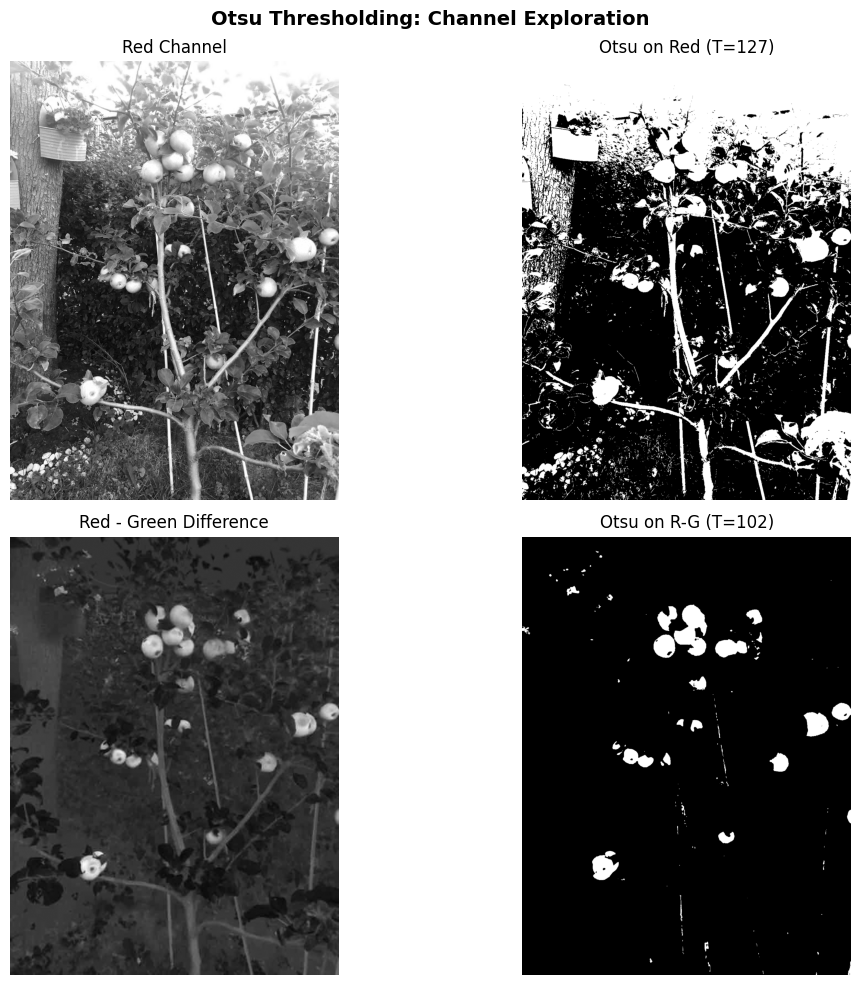

In [47]:
# Visualize Otsu results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Red channel
axes[0, 0].imshow(otsu_results['red']['channel'], cmap='gray')
axes[0, 0].set_title('Red Channel')
axes[0, 0].axis('off')

axes[0, 1].imshow(otsu_results['red']['mask'], cmap='gray')
axes[0, 1].set_title(f'Otsu on Red (T={threshold_red:.0f})')
axes[0, 1].axis('off')

# Red-Green difference
axes[1, 0].imshow(otsu_results['red-green']['channel'], cmap='gray')
axes[1, 0].set_title('Red - Green Difference')
axes[1, 0].axis('off')

axes[1, 1].imshow(otsu_results['red-green']['mask'], cmap='gray')
axes[1, 1].set_title(f'Otsu on R-G (T={threshold_rg:.0f})')
axes[1, 1].axis('off')

plt.suptitle('Otsu Thresholding: Channel Exploration', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

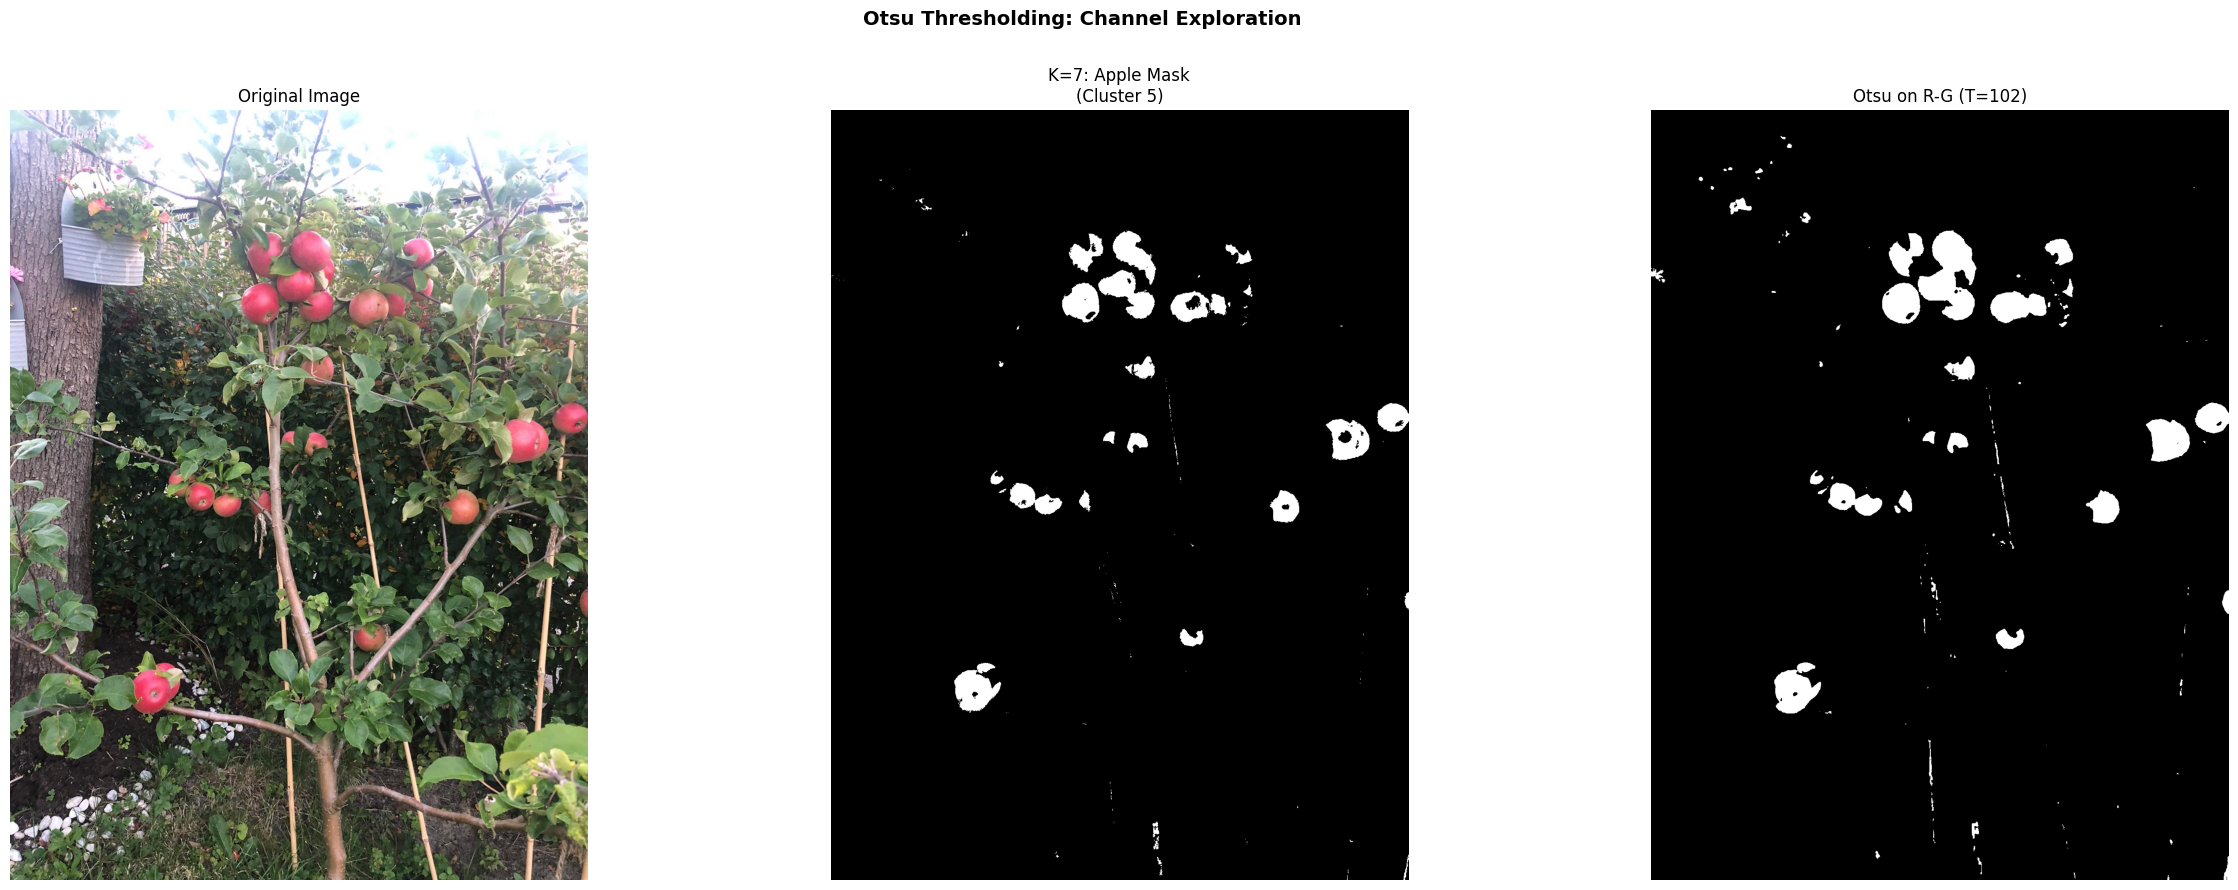

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].imshow(apple_tree)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(apple_mask, cmap='gray')
axes[1].set_title('K=7: Apple Mask\n(Cluster 5)')
axes[1].axis('off')

axes[2].imshow(otsu_results['red-green']['mask'], cmap='gray')
axes[2].set_title(f'Otsu on R-G (T={threshold_rg:.0f})')
axes[2].axis('off')

plt.suptitle('Otsu Thresholding: Channel Exploration', fontsize=14, fontweight='bold')

plt.show()


**Obersvations**

Both Methods Work Well:
- K-Means (K=7, Cluster 5): Captures most apples cleanly
- Otsu on R-G: Nearly identical result
- Performance difference is minimal, both are viable

Method Comparison:
- K-Means: Requires knowing which cluster = apples (needed manual inspection of centroids)
- Otsu R-G: Automatic, no cluster selection needed
- Winner for automation: Otsu R-G (simpler, more repeatable)

Current Mask Quality:
- Large central apples detected well
- Some small specks (noise) visible
- Some apples have holes/gaps in them
- Touching apples appear as merged blobs

For this Mask we first want to remove noise, so we as much as possible only have the apples visible in the mask.

C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\2968142023.py:7: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask_rg, kernel)
C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\2968142023.py:7: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask_rg, kernel)
C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\2968142023.py:7: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(mask_rg, kernel)
C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\2968142023.py:7: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  opened = binary_opening(m

  Radius 1: 63900 pixels remaining (935.0 removed)
  Radius 2: 62430 pixels remaining (2405.0 removed)
  Radius 3: 61175 pixels remaining (3660.0 removed)
  Radius 5: 58596 pixels remaining (6239.0 removed)
  Radius 7: 57387 pixels remaining (7448.0 removed)


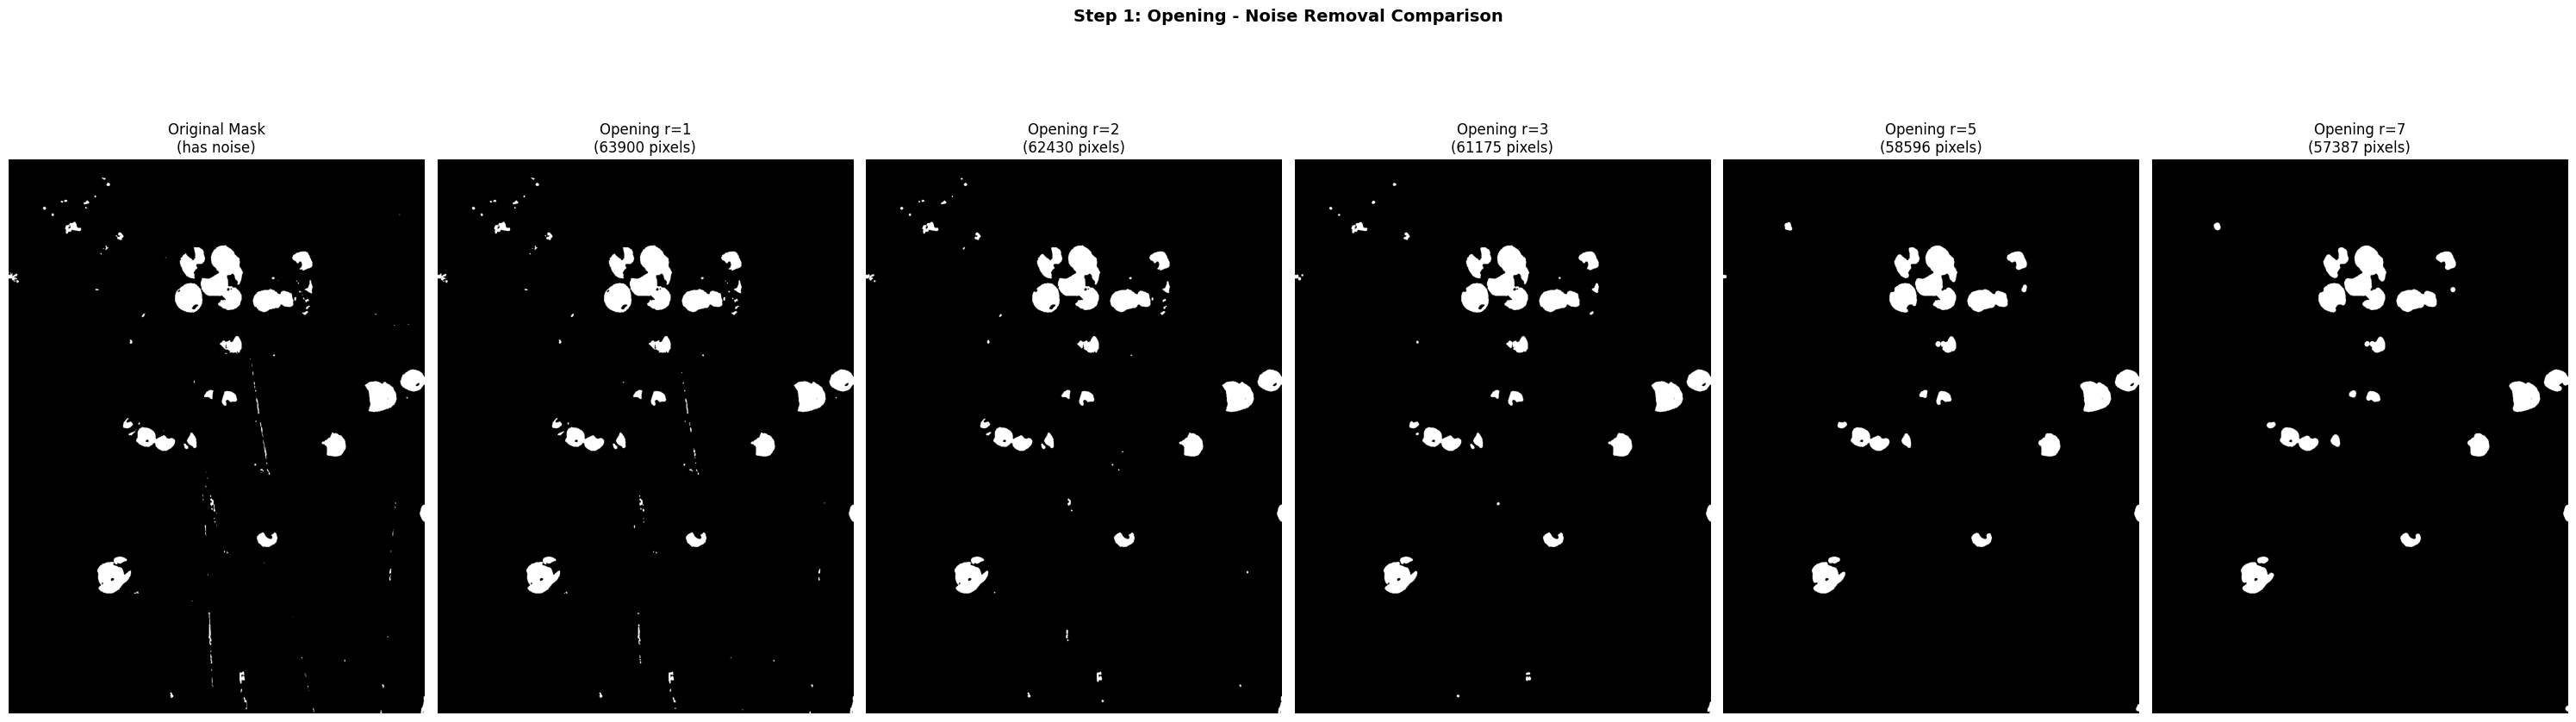

In [ ]:
# Test different radii
opening_radii = [1, 2, 3, 5, 7]
opening_results = {}

for r in opening_radii:
    kernel = disk(r)
    opened = binary_opening(mask_rg, kernel)
    white_pixels = np.sum(opened)
    noise_removed = np.sum(mask_rg) - white_pixels
    
    opening_results[r] = opened
    print(f"  Radius {r}: {white_pixels} pixels remaining ({noise_removed} removed)")

# Visualize comparison
fig, axes = plt.subplots(1, 6, figsize=(30, 10))

axes[0].imshow(mask_rg, cmap='gray')
axes[0].set_title('Original Mask\n(has noise)')
axes[0].axis('off')

for idx, r in enumerate(opening_radii):
    axes[idx+1].imshow(opening_results[r], cmap='gray')
    axes[idx+1].set_title(f'Opening r={r}\n({np.sum(opening_results[r])} pixels)')
    axes[idx+1].axis('off')

plt.suptitle('Step 1: Opening - Noise Removal Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('day11_step1_opening.png', dpi=150, bbox_inches='tight')
plt.show()

Decision: r=5
- Removes small noise fragments (branches, specks) fully
- Preserves apple sizes and shapes
- Considering bias for developement based on this image only

In [82]:
mask_opened = opening_results[5]

Now we need to fill the holes of the apples. This isn't necessary, but it results in visually whole apples.

C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\85592882.py:7: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(mask_opened, kernel)
C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\85592882.py:7: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(mask_opened, kernel)
C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\85592882.py:7: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  closed = binary_closing(mask_opened, kernel)


  Radius 3: 58891 pixels (295 added)
  Radius 5: 59400 pixels (804 added)
  Radius 7: 59896 pixels (1300 added)


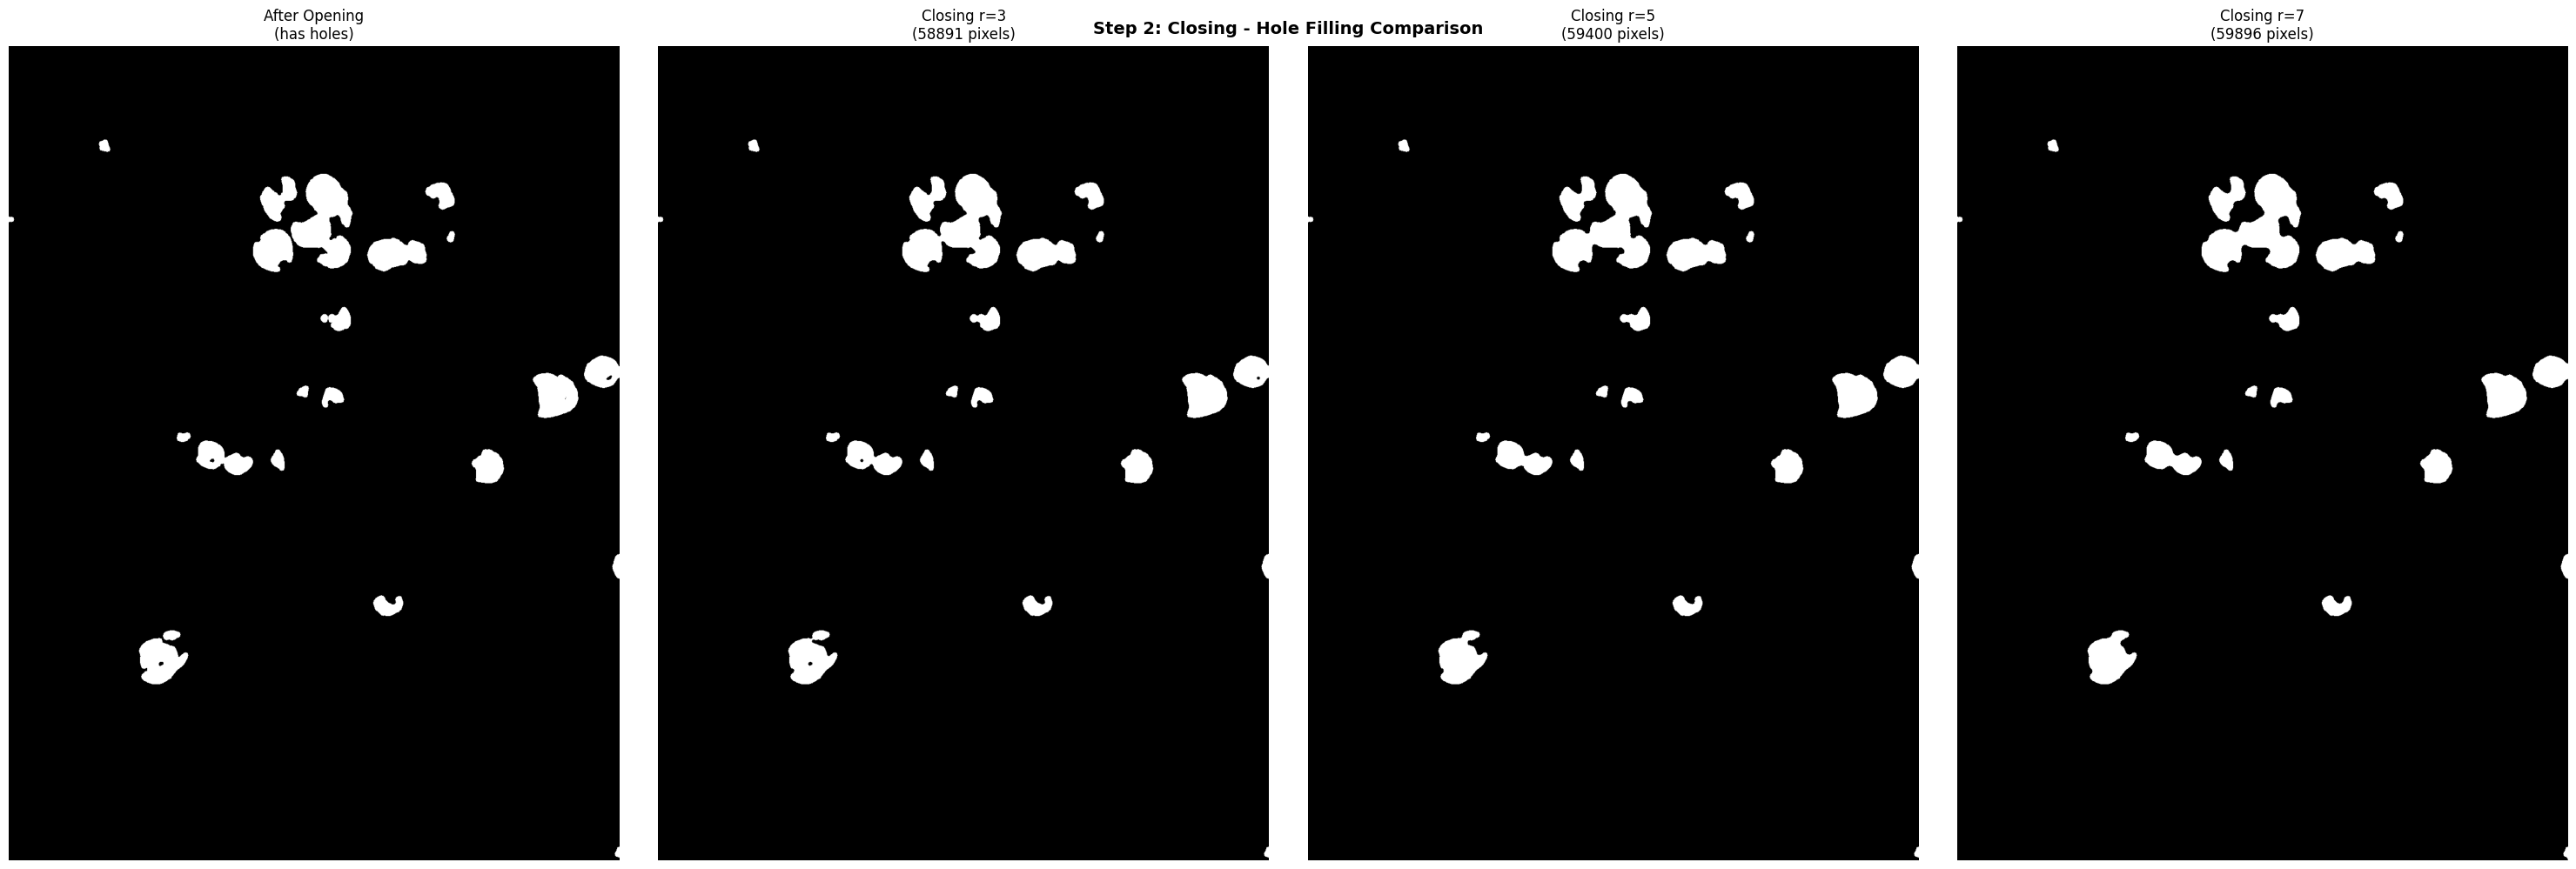

In [83]:
# Test different radii
closing_radii = [3, 5, 7]
closing_results = {}

for r in closing_radii:
    kernel = disk(r)
    closed = binary_closing(mask_opened, kernel)
    white_pixels = np.sum(closed)
    pixels_added = white_pixels - np.sum(mask_opened)
    
    closing_results[r] = closed
    print(f"  Radius {r}: {white_pixels} pixels ({pixels_added} added)")

# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(30, 10))

axes[0].imshow(mask_opened, cmap='gray')
axes[0].set_title('After Opening\n(has holes)')
axes[0].axis('off')

for idx, r in enumerate(closing_radii):
    axes[idx+1].imshow(closing_results[r], cmap='gray')
    axes[idx+1].set_title(f'Closing r={r}\n({np.sum(closing_results[r])} pixels)')
    axes[idx+1].axis('off')

plt.suptitle('Step 2: Closing - Hole Filling Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('day11_step2_closing.png', dpi=150, bbox_inches='tight')
plt.show()

Decision: r = 5
- Moderate change, since the apples were already fairly solid after Otsu segmentation
- Only internal gaps filled is the calyx
- Higher r diminishing returns

In [88]:
mask_closed = closing_results[5]

Finally, since after closing we merged clusters together, we want to seperate them again to be able to identify individual apples in the masked image.

C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\948454508.py:6: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.erosion` instead. Note the pixel shift by 1 for even-sized footprints (see docstring notes).
  eroded = binary_erosion(mask_closed, kernel)


  Radius 2: 52098 pixels (shrunk by 7302)
  Radius 3: 48177 pixels (shrunk by 11223)
  Radius 4: 44800 pixels (shrunk by 14600)


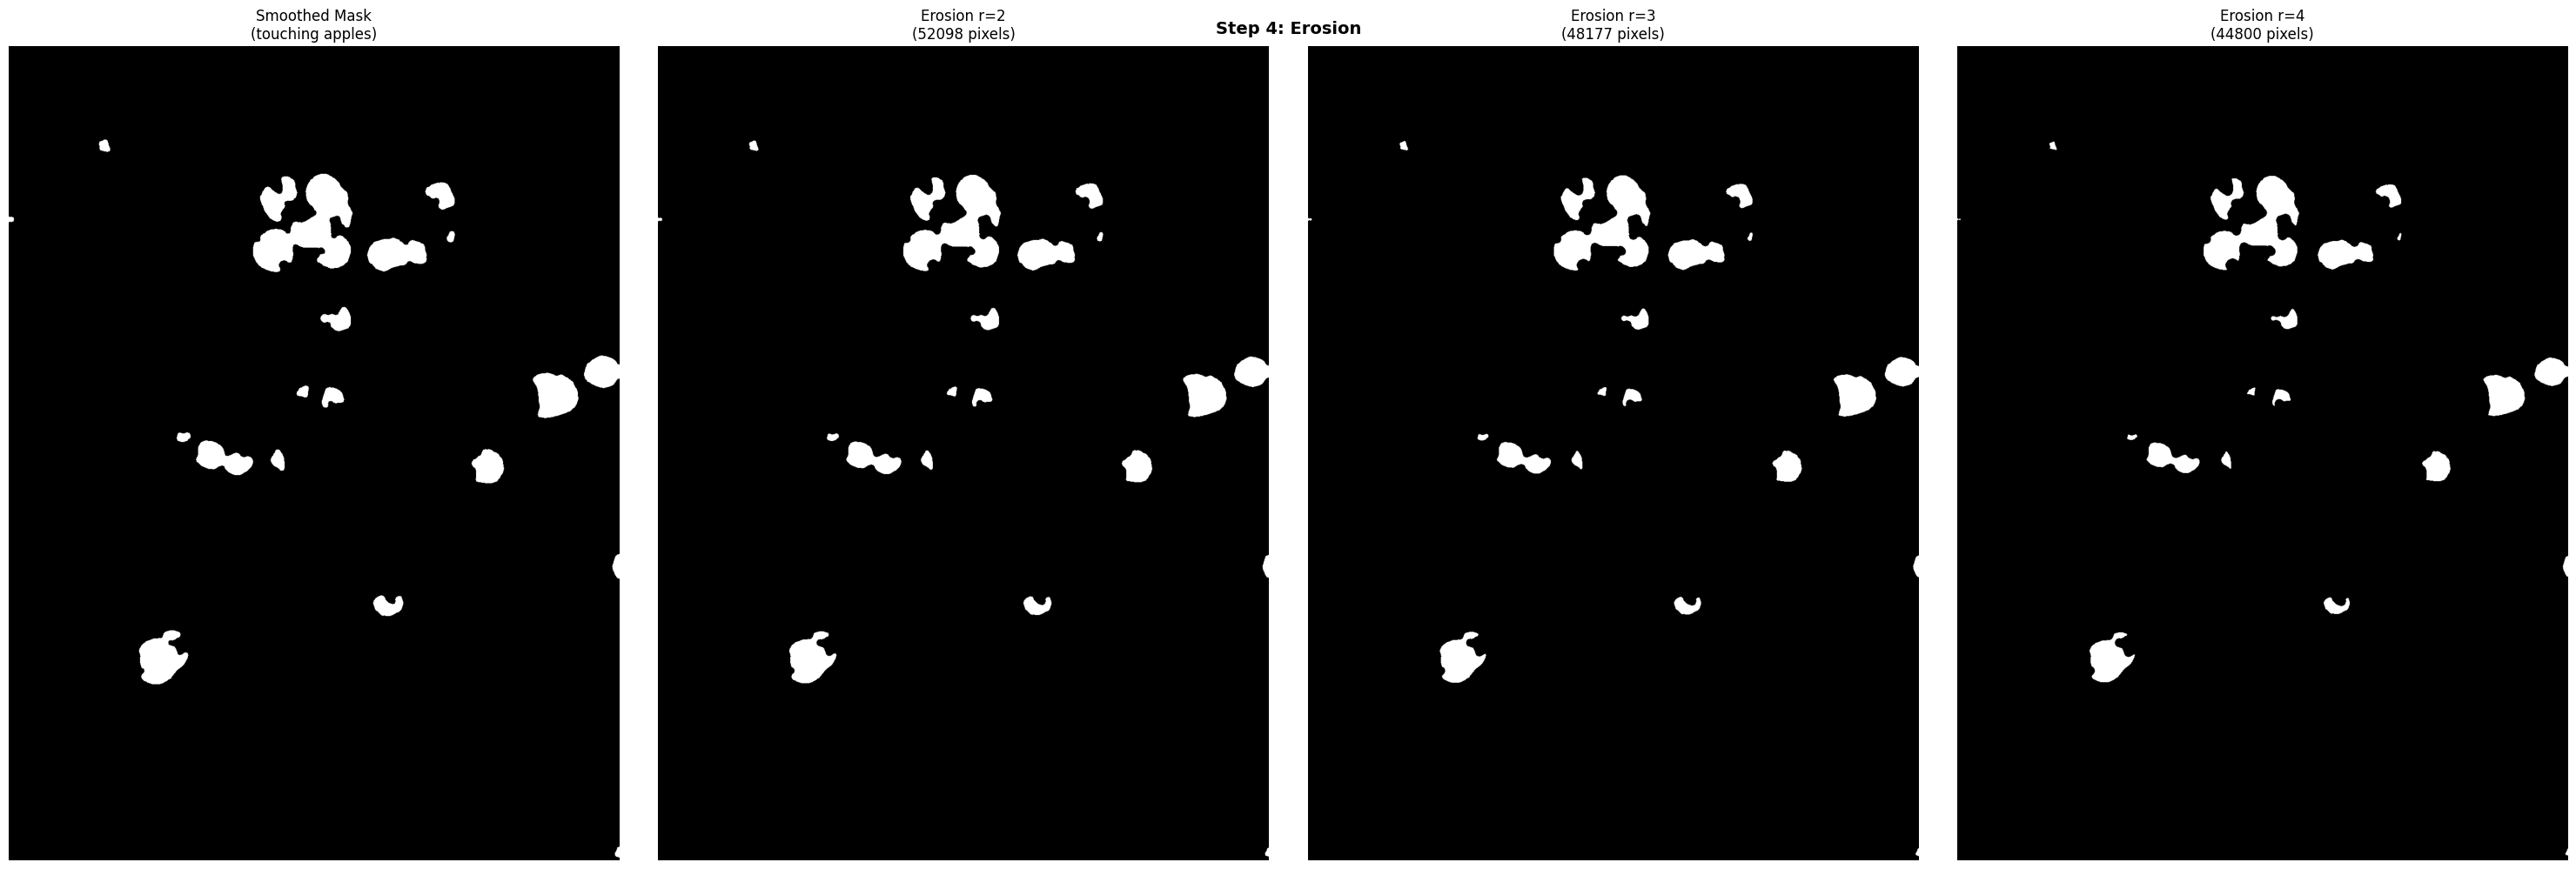

In [90]:
erosion_radii = [2, 3, 4]
erosion_results = {}

for r in erosion_radii:
    kernel = disk(r)
    eroded = binary_erosion(mask_closed, kernel)
    white_pixels = np.sum(eroded)
    
    erosion_results[r] = eroded
    print(f"  Radius {r}: {white_pixels} pixels (shrunk by {np.sum(mask_closed) - white_pixels})")

# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(30, 10))

axes[0].imshow(mask_closed, cmap='gray')
axes[0].set_title('Smoothed Mask\n(touching apples)')
axes[0].axis('off')

for idx, r in enumerate(erosion_radii):
    axes[idx+1].imshow(erosion_results[r], cmap='gray')
    axes[idx+1].set_title(f'Erosion r={r}\n({np.sum(erosion_results[r])} pixels)')
    axes[idx+1].axis('off')

plt.suptitle('Step 4: Erosion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Decision: r = 4

- Clearer segmentation of apples
- Still some clusters of connected apples


In [91]:
final_mask = erosion_results[4]

### Object Extraction

In [93]:
from scipy.ndimage import distance_transform_edt, label
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage import io


Why this range (15-30 px):

- Apple diameter estimate: 40-80 pixels (visible apples range from small to large)
- min_distance = half of typical apple diameter:
    - Range 15-30 covers small-to-medium apple spacing


Too small (<15): Would split single apples (false positives)
Too large (>30): Would merge touching apples (false negatives)

Distance transform computed
  Max distance: 34.1 pixels (apple centers)
  min_distance=15: 24 apples detected
  min_distance=20: 23 apples detected
  min_distance=25: 22 apples detected
  min_distance=30: 21 apples detected


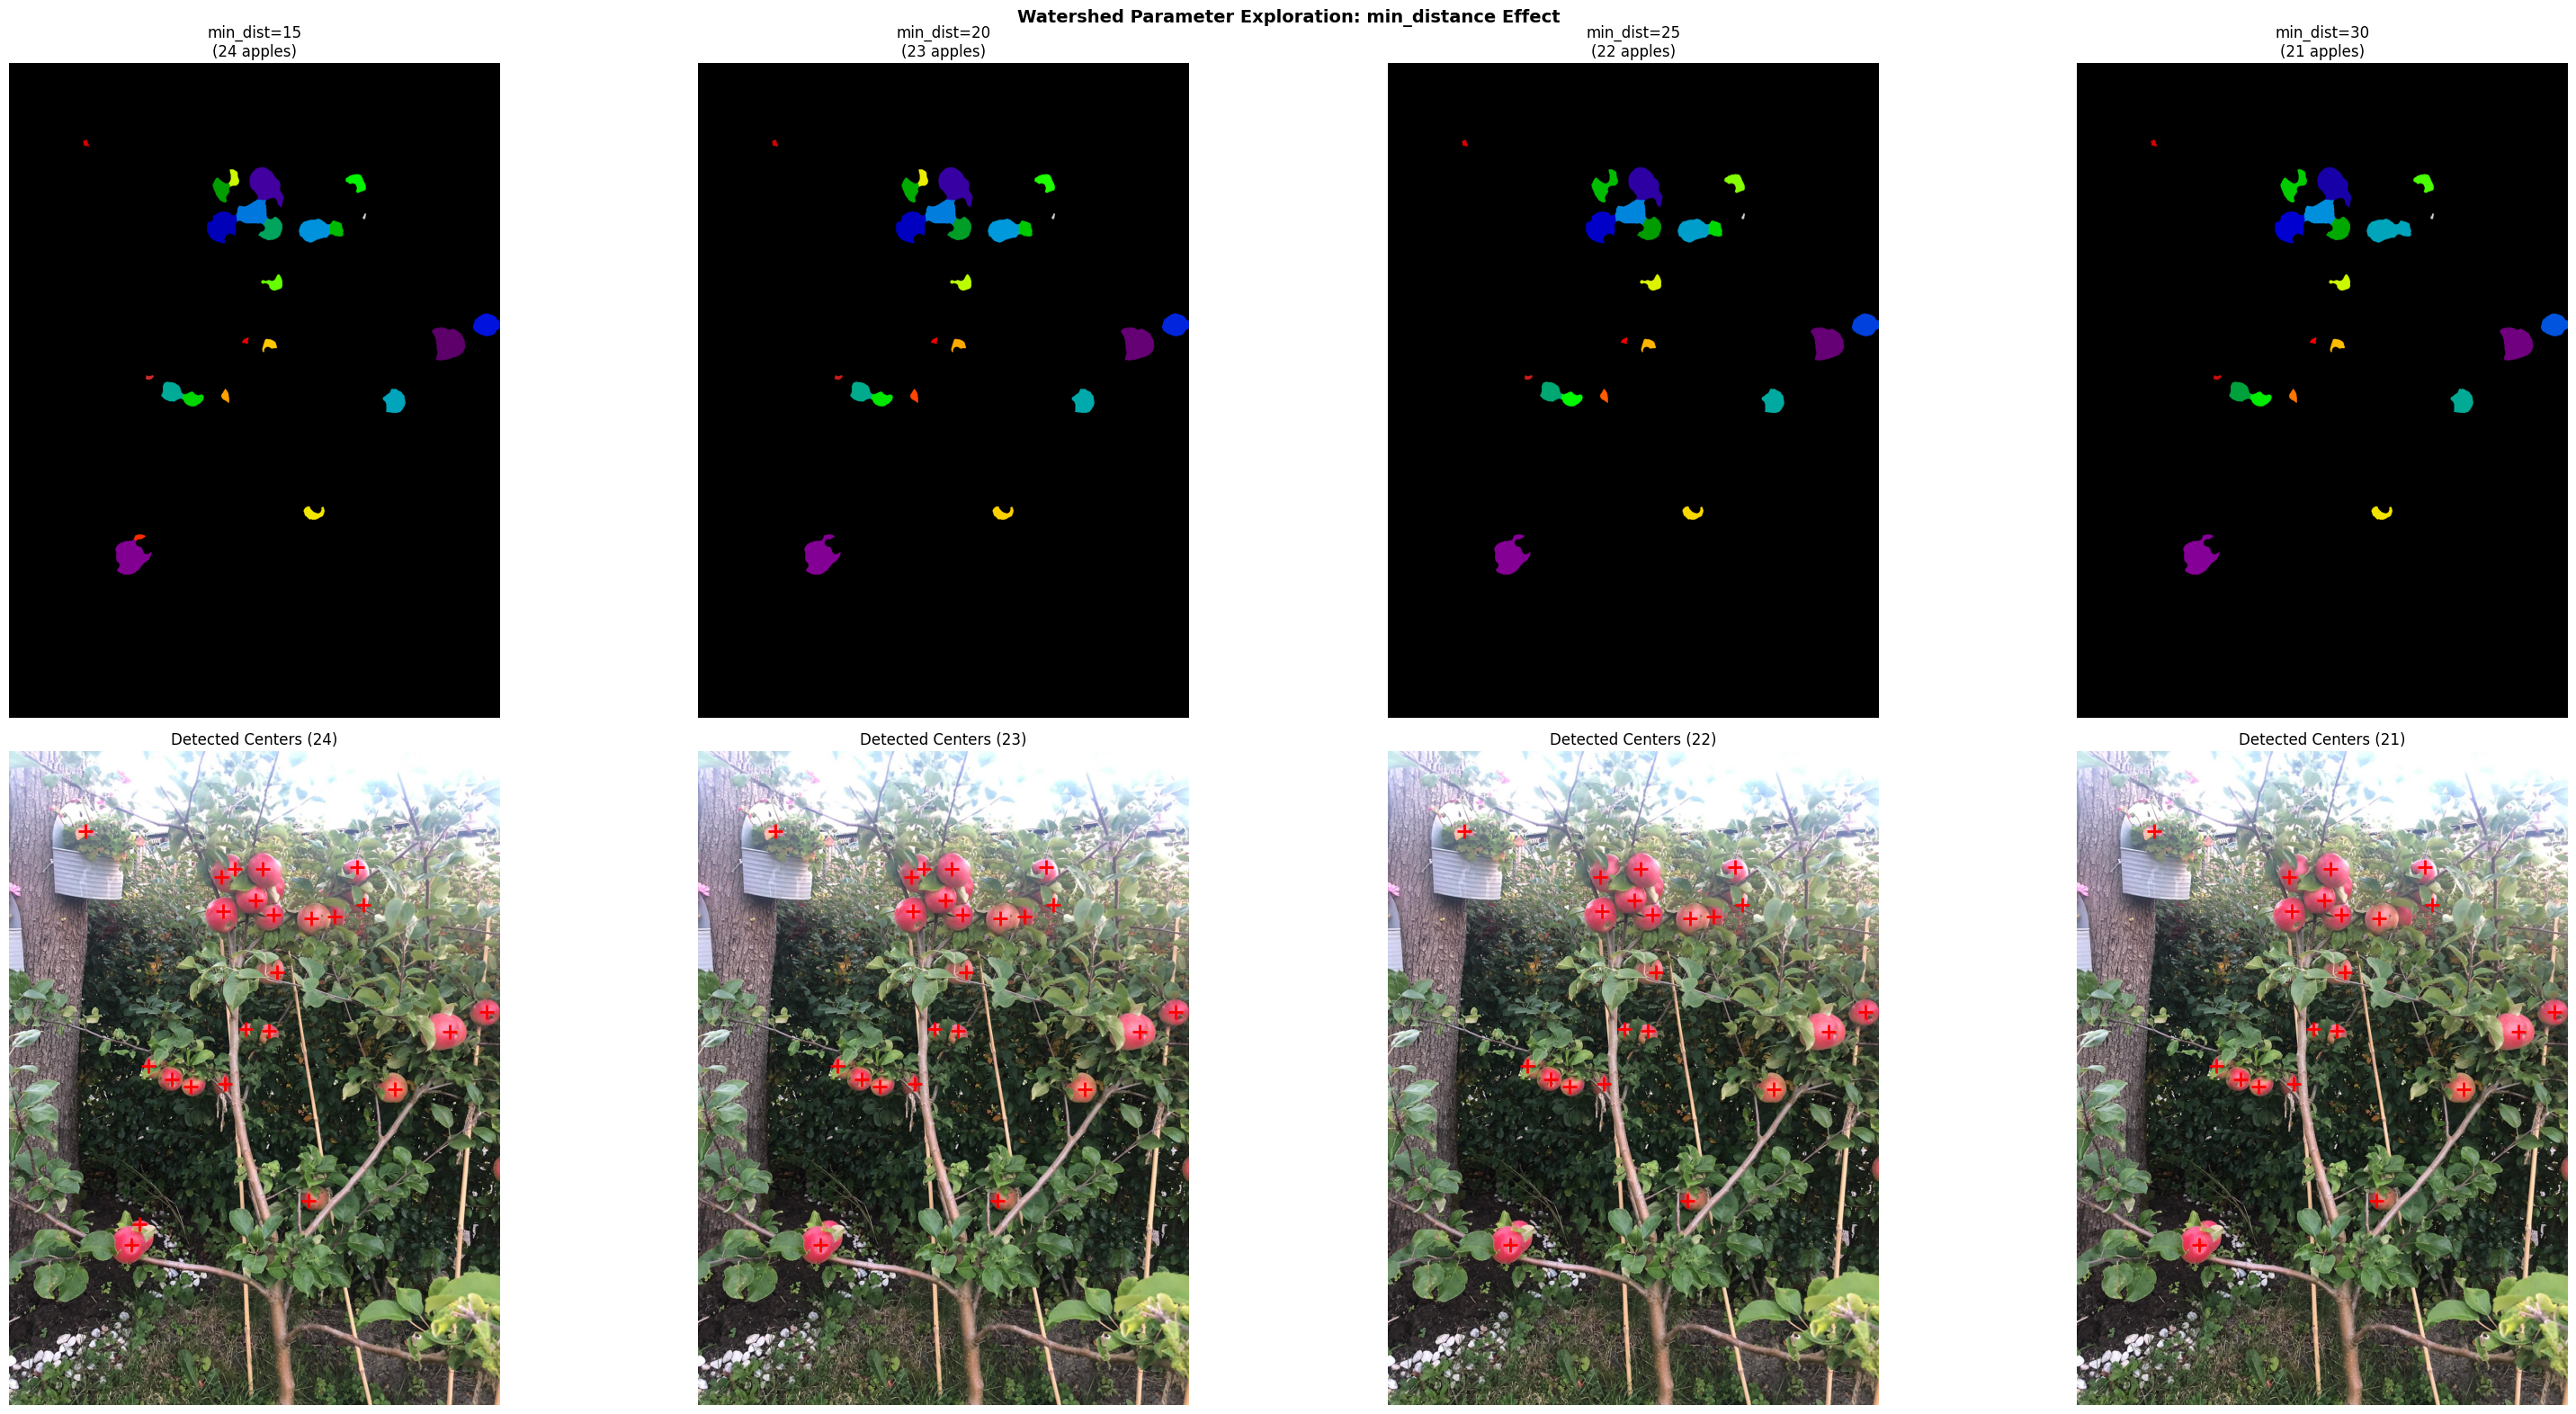

In [113]:
# Compute distance transform (distance from each white pixel to nearest black pixel)
distance = distance_transform_edt(final_mask)

print(f"Distance transform computed")
print(f"  Max distance: {distance.max():.1f} pixels (apple centers)")

# Test different min_distance values for peak detection
min_distances = [15, 20, 25, 30]
watershed_results = {}

for min_dist in min_distances:
    # Find local maxima in distance map (apple centers)
    local_max = peak_local_max(distance, min_distance=min_dist, labels=final_mask)
    
    # Create markers for watershed (number each peak)
    markers = np.zeros(distance.shape, dtype=int)
    for i, (y, x) in enumerate(local_max):
        markers[y, x] = i + 1
    
    # Apply watershed on inverted distance (valleys = apple edges)
    labels_ws = watershed(-distance, markers, mask=final_mask)
    
    num_apples = len(local_max)
    watershed_results[min_dist] = {
        'labels': labels_ws,
        'num_apples': num_apples,
        'peaks': local_max
    }
    
    print(f"  min_distance={min_dist}: {num_apples} apples detected")

# Visualize watershed parameter exploration
fig, axes = plt.subplots(2, 4, figsize=(32, 16))

# Row 1: Markers + watershed results
for idx, min_dist in enumerate(min_distances):
    result = watershed_results[min_dist]
    
    # Show labeled regions
    axes[0, idx].imshow(result['labels'], cmap='nipy_spectral')
    axes[0, idx].set_title(f'min_dist={min_dist}\n({result["num_apples"]} apples)')
    axes[0, idx].axis('off')
    
    # Show peaks on original
    axes[1, idx].imshow(apple_tree)
    for y, x in result['peaks']:
        axes[1, idx].plot(x, y, 'r+', markersize=12, markeredgewidth=2)
    axes[1, idx].set_title(f'Detected Centers ({result["num_apples"]})')
    axes[1, idx].axis('off')

plt.suptitle('Watershed Parameter Exploration: min_distance Effect', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



**Analysis**

Best result: 15px

False Positives (detected but not apples):
- 2 FP
    - 1 FP: Top-left corner: Small red marker on image detected (not an apple)
    - 1 FP: 1 Apple counted double because of seperation by a leave

False Negatives (missed apples):
- 2 FN
    - 1 Apple missed in the top middle cluster
    - 1 Apple missed on the right middle edge (only left curve of the apple visible)


Of 24 apples:
- 22 were found correctly



**Precision** = TP / (TP + FP) = 22 / (22 + 2) = 22/24 = 0.917 = **91.7%**

**Recall** = TP / (TP + FN) = 22 / (22 + 2) = 22/24 = 0.917 = **91.7%**

**F1** = 2 × (Precision × Recall) / (Precision + Recall) = 0.917 = **91.7%**

→ The solution is accepted as per Objectives for the use case.

In [116]:


selected_labels = watershed_results[15]['labels']
num_apples_detected = watershed_results[15]['num_apples']

#### Properies

In [103]:
# Extract region properties
regions = regionprops(selected_labels)

print(f"Total apples detected: {num_apples_detected}")
print(f"Regions extracted: {len(regions)}")


Total apples detected: 24
Regions extracted: 24


In [107]:
# Extract region properties
regions = regionprops(selected_labels)


# Property 1: Area (pixels^2)
areas = [region.area for region in regions]

# Property 2: Equivalent Diameter (pixels) → Real-world size
diameters = [region.equivalent_diameter for region in regions]

# Property 3: Circularity (shape quality) → Defect detection
circularities = []
for region in regions:
    perimeter = region.perimeter
    area = region.area
    if perimeter > 0:
        circ = (4 * np.pi * area) / (perimeter ** 2)
        circularities.append(circ)
    else:
        circularities.append(0)

print(f"\nProperty 1: Area (size grading)")
print(f"  Mean: {np.mean(areas):.1f} pixels^2")
print(f"  Std:  {np.std(areas):.1f} pixels^2")
print(f"  Range: {np.min(areas):.1f} - {np.max(areas):.1f} pixels^2")

print(f"\nProperty 2: Diameter")
print(f"  Mean: {np.mean(diameters):.1f} pixels ({np.mean(diameters)*0.15:.1f} cm estimated)")
print(f"  Range: {np.min(diameters):.1f} - {np.max(diameters):.1f} pixels")

print(f"\nProperty 3: Circularity (1.0 = perfect circle)")
print(f"  Mean: {np.mean(circularities):.3f}")
print(f"  Range: {np.min(circularities):.3f} - {np.max(circularities):.3f}")


Property 1: Area (size grading)
  Mean: 1851.7 pixels^2
  Std:  1573.0 pixels^2
  Range: 72.0 - 4917.0 pixels^2

Property 2: Diameter
  Mean: 43.4 pixels (6.5 cm estimated)
  Range: 9.6 - 79.1 pixels

Property 3: Circularity (1.0 = perfect circle)
  Mean: 0.684
  Range: 0.455 - 0.857


C:\Users\shwet\AppData\Local\Temp\ipykernel_14452\1933740166.py:9: FutureWarning: `RegionProperties.equivalent_diameter` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.equivalent_diameter_area` instead. 
  diameters = [region.equivalent_diameter for region in regions]


In [111]:
# Size classification (for different supply chains)
# Assuming: Small <3000 px^2, Medium 3000-6000 px^2, Large >6000 px^2
small = sum(a < 3000 for a in areas)
medium = sum(3000 <= a <= 6000 for a in areas)
large = sum(a > 6000 for a in areas)

print(f"\nSize Grading (for market):")
print(f"  Small (<3000 px^2):      {small} apples ({small/len(areas)*100:.1f}%)")
print(f"  Medium (3000-6000 px^2): {medium} apples ({medium/len(areas)*100:.1f}%)")
print(f"  Large (>6000 px^2):      {large} apples ({large/len(areas)*100:.1f}%)")


Size Grading (for market):
  Small (<3000 px^2):      18 apples (75.0%)
  Medium (3000-6000 px^2): 6 apples (25.0%)
  Large (>6000 px^2):      0 apples (0.0%)
